### Notes

Created on Thu 28-Jun to help look through the initial stages of developing the fader networks architecture.

Fri 29-Jun: Haven't really used this today. Still all rather messy unfortunately/

Runs in '/home/ubuntu/msc-project-fader-networks'
on aws-big

In [1]:
import os
import sys

os.chdir('../')
os.getcwd()

'/home/ubuntu/msc-project-fader-networks'

In [36]:
import argparse
import visdom
import numpy as np
from tqdm import tqdm

import torch
import torch.optim as optim
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F

from data import NpzFolder, NpzLoader, TBPTTIter
from model import Loop, MaskedMSE
from utils import create_output_dir, wrap, check_grad

import matplotlib.pyplot as plt

import pandas as pd

import notebook_utils as nu

import speaker_recognition as sr

import evaluate_loss_func_for_notebook as el

from sklearn.decomposition import PCA

from sklearn.manifold import TSNE

import sklearn.metrics.pairwise as pw

from IPython.display import Audio
import IPython.display

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
# location of the VCTK dataset
vctk_folder = '/home/ubuntu/VCTK-Corpus/'

# location of the raw pre-calculated feature files for VCTK from Jiameng
vctk_prebuilt_raw_folder = '/home/ubuntu/vctk-16khz-cmu-no-boundaries/'

# location of the float32, train/validation files for VCTK-all
vctk_precalc_folder = '/home/ubuntu/loop/data/vctk-16khz-cmu-no-boundaries-all'

#vctk_raw_folder = '/home/ubuntu/VCTK-Corpus/'

In [4]:
gpu = 0
seed = 1
data = '/home/ubuntu/loop/data/vctk'
nspk = 22
max_seq_len = 1000
seq_len = 100
batch_size = 64

In [5]:
torch.cuda.set_device(gpu)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

In [6]:
#checkpoint = 'models/vctk/bestmodel.pth'

# model checkpoint
checkpoint_file = '/home/ubuntu/loop/checkpoints/vctk-16khz-cmu-no-boundaries-all-noise-2/bestmodel.pth'
#checkpoint_file = 'checkpoints/vctk-16khz-cmu-no-boundaries-all/lastmodel.pth'

# data for this model
data='/home/ubuntu/loop/data/vctk-16khz-cmu-no-boundaries-all'

# WORLD feature normalisation data
norm_path = '/home/ubuntu/loop/data/vctk-16khz-cmu-no-boundaries-all/norm_info/norm.dat'

# output embeddings to a file
output_file = '/tmp/embedding_file.npy'

In [7]:
speaker_info = nu.get_vctk_speaker_info()

In [8]:
loader = el.get_loader(data_path = vctk_precalc_folder)

loop_speaker_lookup = loader.dataset.speakers # dict['p330'] = 88

# Create dict from IDs used inside VoiceLoop to VCTK speaker IDs
speaker_list_vctk = [int(k[1:])for k in loop_speaker_lookup.keys()] # list of VCTK speaker IDs; strip out the 'p'
speaker_dict_vctk_to_loop = dict(zip(speaker_list_vctk, loop_speaker_lookup.values())) # dict['vctk_id] = sim_id
speaker_dict_loop_to_vctk = dict(zip(loop_speaker_lookup.values(), speaker_list_vctk)) # dict['sim_id] = vctk_id

# get dataframe for VCTK reference data indexed by VoiceLoop speaker ID
tmp = pd.DataFrame.from_dict(speaker_dict_loop_to_vctk, orient='index', columns=['id'])
speaker_info_loop = pd.merge(speaker_info, tmp)

# examples
speaker_info_loop.head()

,id,age,gender,accents,region
0,225,23,F,English,Southern England
1,226,22,M,English,Surrey
2,227,38,M,English,Cumbria
3,228,22,F,English,Southern England
4,229,23,F,English,Southern England


In [51]:
checkpoint_args_path = os.path.join(os.path.dirname(checkpoint_file), 'args.pth')
checkpoint_args = torch.load(checkpoint_args_path)

# restore the model from the checkpoint
checkpoint = torch.load(checkpoint_file,
                     map_location=lambda storage, loc: storage)

model = Loop(checkpoint_args[0])

model.load_state_dict(checkpoint)

# extract the speaker embeddings from the model
embeddings = model.encoder.lut_s.weight.data.numpy()

# save the embeddings
np.save(output_file, embeddings)

In [52]:
# view parameters used the train the model
checkpoint_args[0]

Namespace(K=10, attention_alignment=0.05, batch_size=32, checkpoint='checkpoints/vctk-16khz-cmu-no-boundaries-all/bestmodel.pth', clip_grad=0.5, data='data/vctk-16khz-cmu-no-boundaries-all', epochs=90, expName='checkpoints/vctk-16khz-cmu-no-boundaries-all-noise-2', gpu=0, hidden_size=256, hidden_size_speakers=256, ignore_grad=10000.0, lr=0.0001, max_seq_len=1000, mem_size=20, noise=2, nspk=108, output_size=63, seed=1, seq_len=500, visualize=False, vocabulary_size=44)

In [53]:
# view model structure
model

Loop(
  (encoder): Encoder(
    (lut_p): Embedding(44, 256, max_norm=1.0)
    (lut_s): Embedding(108, 256, max_norm=1.0)
  )
  (decoder): Decoder(
    (attn): GravesAttention(
      (sm): Softmax()
      (N_a): Sequential(
        (0): Linear(in_features=6380, out_features=638, bias=True)
        (1): ReLU()
        (2): Linear(in_features=638, out_features=30, bias=True)
      )
    )
    (N_o): Sequential(
      (0): Linear(in_features=6380, out_features=638, bias=True)
      (1): ReLU()
      (2): Linear(in_features=638, out_features=256, bias=True)
    )
    (output): Linear(in_features=256, out_features=63, bias=True)
    (N_u): Sequential(
      (0): Linear(in_features=6380, out_features=638, bias=True)
      (1): ReLU()
      (2): Linear(in_features=638, out_features=319, bias=True)
    )
    (F_u): Linear(in_features=256, out_features=256, bias=True)
    (F_o): Linear(in_features=256, out_features=256, bias=True)
  )
)

In [54]:
if embeddings.shape[0] == 108:
    embeddings = np.delete(embeddings, -1, axis=0)

In [55]:
embeddings.shape

(107, 256)

In [56]:
num_examples = embeddings.shape[0]

In [57]:
b_male = np.array(speaker_info_loop.gender == 'M')
all_data = (embeddings, b_male)

In [58]:
idx_rand = np.random.permutation(num_examples)
idx_train = idx_rand[:100]
idx_valid = idx_rand[100:]
train_data =  (embeddings[idx_train], b_male[idx_train])
valid_data = (embeddings[idx_valid], b_male[idx_valid])

In [497]:
class RecognitionNet(nn.Module):
    def __init__(self):
        super(RecognitionNet, self).__init__()
        
        self.fc1 = nn.Linear(256, 32)
        self.fc2 = nn.Linear(32, 16)
        self.fc3 = nn.Linear(16, 2)
        
        #self.fc1 = nn.Linear(256, 16)
        #self.fc2 = nn.Linear(16, 2)

    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        #x = F.softmax(x, dim=0)
    
        #x = self.fc1(x)
        #x = F.relu(x)
        #x = self.fc2(x)
        #x = F.softmax(x, dim=0)
        
        return x
    
    def cuda(self, device_id=None):
        nn.Module.cuda(self, device_id)

In [567]:
seq_len = 300
epoch = 1
num_epochs = 5

In [568]:
net

RecognitionNet(
  (fc1): Linear(in_features=256, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=16, bias=True)
  (fc3): Linear(in_features=16, out_features=2, bias=True)
)

## todo next
* do the evaluate function
* do the training function


In [367]:
data = training_data
epoch = 1

In [400]:
def evaluate(net, data, criterion):
    total_correct = 0.
    total_samples = 0.

    num_samples = len(data[0])
    all_pred = []
    all_gt = []
    all_correct = []

    x = data[0]
    y = data[1]


    x_wrap = Variable(torch.from_numpy(x)).cuda() #.unsqueeze(0)

    y_wrap = Variable(torch.from_numpy(y.astype('uint8')).type(torch.FloatTensor)).cuda()

    output = net(x_wrap)

    output.shape

    loss = criterion(output, y_wrap.type(torch.cuda.LongTensor))

    #total += loss.data[0]

    y_pred = output.cpu().data.numpy().argmax(axis=1)
    correct_pred = y == y_pred
    num_correct_pred = np.sum(correct_pred)

    accuracy = 1.0*num_correct_pred / num_samples

        #return avg, accuracy, all_pred, all_gt, all_correct
    return accuracy

In [563]:
b_male = np.full(num_examples, False)
b_male = np.random.choice([True, False], num_examples)
b_male = np.array(speaker_info_loop.gender == 'M')

idx_rand = np.random.permutation(num_examples)
cutoff = 50
idx_train = idx_rand[:cutoff]
idx_valid = idx_rand[cutoff:]
train_data =  (embeddings[idx_train], b_male[idx_train])
valid_data = (embeddings[idx_valid], b_male[idx_valid])

In [564]:
net = RecognitionNet()
net.cuda()
net.train()

criterion = nn.CrossEntropyLoss().cuda()
optimizer = optim.Adam(net.parameters(), lr=0.001)

In [565]:
num_epochs = 500
train_losses = np.zeros(num_epochs)
train_accuracy = np.zeros(num_epochs)
valid_accuracy = np.zeros(num_epochs)

print "Initialized: train %0.3f / validation %0.3f" % (evaluate(net, train_data, criterion), evaluate(net, valid_data, criterion))

for epoch in range(num_epochs):
    
    num_samples = len(train_data[0])
    all_pred = []
    all_gt = []
    all_correct = []

    x = train_data[0]
    y = train_data[1]

    x_wrap = Variable(torch.from_numpy(x)).cuda() #.unsqueeze(0)

    y_wrap = Variable(torch.from_numpy(y.astype('uint8')).type(torch.FloatTensor)).cuda()

    optimizer.zero_grad()
    
    # Forward
    output = net(x_wrap)  

    loss = criterion(output, y_wrap.type(torch.cuda.LongTensor))
    
    # Backward
    loss.backward()
    
    optimizer.step()

    #print loss.cpu().data.numpy()[0]
    this_train_accuracy = evaluate(net, train_data, criterion)
    this_valid_accuracy = evaluate(net, valid_data, criterion)
    train_accuracy[epoch] = this_train_accuracy
    valid_accuracy[epoch] = this_valid_accuracy
    print "Epoch %d: loss %0.6f, train %0.3f / validation %0.3f" % (epoch, loss.cpu().data.numpy()[0], this_train_accuracy, this_valid_accuracy)

    
    #avg = total / len(train_loader)
    #train_losses.append(avg)


#logging.info('====> Train set loss: {:.4f}'.format(avg))

Initialized: train 0.620 / validation 0.526
Epoch 0: loss 0.689026, train 0.620 / validation 0.526
Epoch 1: loss 0.688024, train 0.620 / validation 0.526
Epoch 2: loss 0.687031, train 0.620 / validation 0.526
Epoch 3: loss 0.686045, train 0.620 / validation 0.526
Epoch 4: loss 0.685073, train 0.620 / validation 0.526
Epoch 5: loss 0.684109, train 0.620 / validation 0.526
Epoch 6: loss 0.683145, train 0.620 / validation 0.526
Epoch 7: loss 0.682174, train 0.620 / validation 0.526
Epoch 8: loss 0.681193, train 0.620 / validation 0.526
Epoch 9: loss 0.680201, train 0.620 / validation 0.526
Epoch 10: loss 0.679204, train 0.620 / validation 0.526
Epoch 11: loss 0.678188, train 0.620 / validation 0.526
Epoch 12: loss 0.677148, train 0.620 / validation 0.526
Epoch 13: loss 0.676082, train 0.620 / validation 0.526
Epoch 14: loss 0.674978, train 0.620 / validation 0.526
Epoch 15: loss 0.673831, train 0.620 / validation 0.526
Epoch 16: loss 0.672643, train 0.620 / validation 0.526
Epoch 17: loss

Epoch 176: loss 0.034440, train 1.000 / validation 1.000
Epoch 177: loss 0.033723, train 1.000 / validation 1.000
Epoch 178: loss 0.033028, train 1.000 / validation 1.000
Epoch 179: loss 0.032354, train 1.000 / validation 1.000
Epoch 180: loss 0.031700, train 1.000 / validation 1.000
Epoch 181: loss 0.031067, train 1.000 / validation 1.000
Epoch 182: loss 0.030452, train 1.000 / validation 1.000
Epoch 183: loss 0.029855, train 1.000 / validation 1.000
Epoch 184: loss 0.029276, train 1.000 / validation 1.000
Epoch 185: loss 0.028714, train 1.000 / validation 1.000
Epoch 186: loss 0.028168, train 1.000 / validation 1.000
Epoch 187: loss 0.027638, train 1.000 / validation 1.000
Epoch 188: loss 0.027123, train 1.000 / validation 1.000
Epoch 189: loss 0.026622, train 1.000 / validation 1.000
Epoch 190: loss 0.026135, train 1.000 / validation 1.000
Epoch 191: loss 0.025662, train 1.000 / validation 1.000
Epoch 192: loss 0.025202, train 1.000 / validation 1.000
Epoch 193: loss 0.024754, train

Epoch 362: loss 0.004140, train 1.000 / validation 1.000
Epoch 363: loss 0.004112, train 1.000 / validation 1.000
Epoch 364: loss 0.004084, train 1.000 / validation 1.000
Epoch 365: loss 0.004057, train 1.000 / validation 1.000
Epoch 366: loss 0.004029, train 1.000 / validation 1.000
Epoch 367: loss 0.004002, train 1.000 / validation 1.000
Epoch 368: loss 0.003976, train 1.000 / validation 1.000
Epoch 369: loss 0.003949, train 1.000 / validation 1.000
Epoch 370: loss 0.003923, train 1.000 / validation 1.000
Epoch 371: loss 0.003898, train 1.000 / validation 1.000
Epoch 372: loss 0.003872, train 1.000 / validation 1.000
Epoch 373: loss 0.003847, train 1.000 / validation 1.000
Epoch 374: loss 0.003822, train 1.000 / validation 1.000
Epoch 375: loss 0.003797, train 1.000 / validation 1.000
Epoch 376: loss 0.003772, train 1.000 / validation 1.000
Epoch 377: loss 0.003748, train 1.000 / validation 1.000
Epoch 378: loss 0.003724, train 1.000 / validation 1.000
Epoch 379: loss 0.003700, train

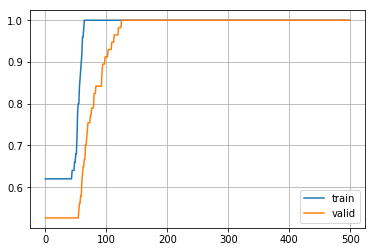

In [566]:
plt.plot(range(num_epochs), train_accuracy)
plt.plot(range(num_epochs), valid_accuracy)
plt.grid(True)
plt.legend(('train', 'valid'))
plt.show()

In [561]:
sum(p.numel() for p in net.parameters() if p.requires_grad)

8786

## TODO next...
* try learning on a random class vector. Should get bad validation performance...


In [597]:
import model_discriminator as md

In [598]:
speaker_loop_info = md.get_speaker_info_for_discriminator()

In [599]:
embeddings = md.get_speaker_embeddings()

In [632]:
train_data, valid_data = md.get_train_valid_split(embeddings, speaker_info_loop)

In [633]:
net, criterion, optimizer = md.build_discriminator()

In [634]:
num_epochs = 500
net, train_accuracy, valid_accuracy, train_loss, valid_loss = md.train_discriminator(net, train_data, valid_data, criterion, optimizer, num_epochs=num_epochs)

Initialized: train 0.600 / validation 0.333
Epoch 0: loss 0.691281, train 0.600 / validation 0.333
Epoch 1: loss 0.690143, train 0.600 / validation 0.333
Epoch 2: loss 0.689019, train 0.600 / validation 0.333
Epoch 3: loss 0.687899, train 0.600 / validation 0.333
Epoch 4: loss 0.686791, train 0.600 / validation 0.333
Epoch 5: loss 0.685687, train 0.600 / validation 0.333
Epoch 6: loss 0.684586, train 0.600 / validation 0.333
Epoch 7: loss 0.683491, train 0.600 / validation 0.333
Epoch 8: loss 0.682390, train 0.600 / validation 0.333
Epoch 9: loss 0.681278, train 0.600 / validation 0.333
Epoch 10: loss 0.680182, train 0.600 / validation 0.333
Epoch 11: loss 0.679096, train 0.600 / validation 0.333
Epoch 12: loss 0.678014, train 0.600 / validation 0.333
Epoch 13: loss 0.676944, train 0.600 / validation 0.333
Epoch 14: loss 0.675831, train 0.600 / validation 0.333
Epoch 15: loss 0.674656, train 0.600 / validation 0.333
Epoch 16: loss 0.673420, train 0.600 / validation 0.333
Epoch 17: loss

Epoch 180: loss 0.020808, train 1.000 / validation 1.000
Epoch 181: loss 0.020325, train 1.000 / validation 1.000
Epoch 182: loss 0.019860, train 1.000 / validation 1.000
Epoch 183: loss 0.019411, train 1.000 / validation 1.000
Epoch 184: loss 0.018977, train 1.000 / validation 1.000
Epoch 185: loss 0.018559, train 1.000 / validation 1.000
Epoch 186: loss 0.018154, train 1.000 / validation 1.000
Epoch 187: loss 0.017764, train 1.000 / validation 1.000
Epoch 188: loss 0.017387, train 1.000 / validation 1.000
Epoch 189: loss 0.017022, train 1.000 / validation 1.000
Epoch 190: loss 0.016670, train 1.000 / validation 1.000
Epoch 191: loss 0.016330, train 1.000 / validation 1.000
Epoch 192: loss 0.016000, train 1.000 / validation 1.000
Epoch 193: loss 0.015681, train 1.000 / validation 1.000
Epoch 194: loss 0.015372, train 1.000 / validation 1.000
Epoch 195: loss 0.015073, train 1.000 / validation 1.000
Epoch 196: loss 0.014782, train 1.000 / validation 1.000
Epoch 197: loss 0.014501, train

Epoch 362: loss 0.002426, train 1.000 / validation 1.000
Epoch 363: loss 0.002410, train 1.000 / validation 1.000
Epoch 364: loss 0.002394, train 1.000 / validation 1.000
Epoch 365: loss 0.002377, train 1.000 / validation 1.000
Epoch 366: loss 0.002361, train 1.000 / validation 1.000
Epoch 367: loss 0.002346, train 1.000 / validation 1.000
Epoch 368: loss 0.002330, train 1.000 / validation 1.000
Epoch 369: loss 0.002314, train 1.000 / validation 1.000
Epoch 370: loss 0.002299, train 1.000 / validation 1.000
Epoch 371: loss 0.002284, train 1.000 / validation 1.000
Epoch 372: loss 0.002269, train 1.000 / validation 1.000
Epoch 373: loss 0.002254, train 1.000 / validation 1.000
Epoch 374: loss 0.002239, train 1.000 / validation 1.000
Epoch 375: loss 0.002225, train 1.000 / validation 1.000
Epoch 376: loss 0.002210, train 1.000 / validation 1.000
Epoch 377: loss 0.002196, train 1.000 / validation 1.000
Epoch 378: loss 0.002182, train 1.000 / validation 1.000
Epoch 379: loss 0.002168, train

In [ ]:
plt.figure(figsize=(14,4))
plt.subplot(1,2,1)
plt.plot(range(num_epochs), train_accuracy)
plt.plot(range(num_epochs), valid_accuracy)
plt.grid(True)
plt.legend(('train', 'valid'))

plt.subplot(1,2,2)
plt.plot(range(num_epochs), train_loss)
plt.plot(range(num_epochs), valid_loss)
plt.grid(True)
plt.legend(('train', 'valid'))

plt.show()

In [45]:
r = torch.LongTensor(10).random_(2)

In [46]:
r


 0
 1
 0
 0
 1
 0
 1
 0
 1
 0
[torch.LongTensor of size 10]

In [47]:
(r + torch.LongTensor(10).random_(2 - 1) + 1) % 2


 1
 0
 1
 1
 0
 1
 0
 1
 0
 1
[torch.LongTensor of size 10]

In [64]:
train_data[1]

array([False, False, False, False, False,  True,  True,  True, False,
        True,  True,  True,  True,  True,  True,  True,  True, False,
       False,  True,  True,  True,  True, False, False, False, False,
       False,  True,  True,  True, False, False, False, False, False,
       False,  True,  True,  True,  True,  True, False, False,  True,
       False, False, False, False, False,  True,  True, False, False,
        True,  True, False, False, False, False,  True,  True, False,
       False, False, False,  True, False, False, False,  True, False,
       False, False, False, False,  True, False, False, False,  True,
        True, False, False,  True, False,  True,  True, False, False,
       False,  True, False,  True,  True,  True,  True, False,  True, False], dtype=bool)

In [63]:
(train_data[1] + 1) % 2

array([1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0,
       1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1,
       1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1,
       1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0,
       1, 0, 0, 0, 0, 1, 0, 1])

In [64]:
tmp = speaker_info_loop[10:11].copy()

In [44]:
tmp.age = 25
tmp.index.set_value(tmp.index, 10, 107)
tmp

,id,age,gender,accents,region
107,236,25,F,English,Manchester


In [61]:
tmp.reset_index(inplace=True)

In [ ]:
tmp.drop('index', axis = 1, inplace=True)
df["Country"].replace("Republic of Korea", value="South Korea", inplace=True)
df.set_index("Country", inplace=True)

In [56]:
tmp.reset_index(inplace=True)

In [68]:
tmp.index.set_value(107)

TypeError: set_value() takes exactly 4 arguments (2 given)

In [70]:
pd.concat([speaker_info_loop, tmp], ignore_index=True)

,id,age,gender,accents,region
0,225,23,F,English,Southern England
1,226,22,M,English,Surrey
2,227,38,M,English,Cumbria
3,228,22,F,English,Southern England
4,229,23,F,English,Southern England
5,230,22,F,English,Stockton-on-tees
6,231,23,F,English,Southern England
7,232,23,M,English,Southern England
8,233,23,F,English,Staffordshire
9,234,22,F,Scottish,West Dumfries


In [37]:
tmp.index.set_value(tmp.index, 10, 107)

### Cross-Entropy Playing

In [79]:
t = torch.rand(10) > 0.5

In [88]:
tt = torch.stack([t, 1-t], dim=1)

In [117]:
output = Variable(torch.FloatTensor([0,0,0,1])).view(1, -1)
target = Variable(torch.LongTensor([3]))
output*0

Variable containing:
 0  0  0  0
[torch.FloatTensor of size 1x4]

In [123]:
criterion = nn.BCELoss()
loss = criterion(output, output*1e10)
print(loss)

Variable containing:
-6.9078e+10
[torch.FloatTensor of size 1]



### Look at saved speaker embeddings

In [9]:
saved_embeddings = np.load('start_embeddings.npy')
#saved_embeddings = np.load('train_embeddings_random.npy')
#saved_embeddings = np.load('train_embeddings_min.npy')
saved_embeddings = np.load('train_embeddings_last.npy')

In [10]:
embeddings = saved_embeddings[0]
speaker_info = saved_embeddings[1]

In [11]:
print "accuracy: %.3f" % saved_embeddings[2]

accuracy: 0.632


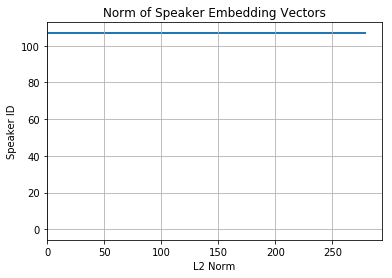

In [12]:
# plot norm of speaker embeddings
plt.barh(range(embeddings.shape[0]), np.sum(embeddings**2,1))
plt.grid(True)
plt.xlabel('L2 Norm')
plt.ylabel('Speaker ID')
plt.title('Norm of Speaker Embedding Vectors')
plt.show()

In [13]:
if embeddings.shape[0] == 108:
    embeddings = np.delete(embeddings, -1, axis=0)

In [14]:
# PCA
pca = PCA(n_components=2)
pca_fit = pca.fit_transform(embeddings)

# t-sne
tsne = TSNE(n_components=2)
tsne_fit = tsne.fit_transform(embeddings)

In [15]:
pca.explained_variance_ratio_

array([ 0.03087769,  0.02831514], dtype=float32)

In [16]:
idx_m = speaker_info['gender'] == 'M'
idx_f = speaker_info['gender'] == 'F'

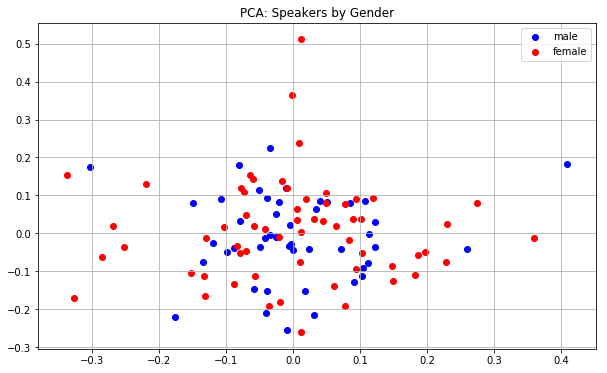

In [17]:
plt.figure(figsize=(10,6))
m_plot = plt.scatter(pca_fit[idx_m, 0], pca_fit[idx_m, 1], c='b', label='male')
f_plot = plt.scatter(pca_fit[idx_f, 0], pca_fit[idx_f, 1], c='r', label='female')
leg = plt.legend(handles=[m_plot, f_plot])
plt.grid(True)
plt.title('PCA: Speakers by Gender')
plt.show()

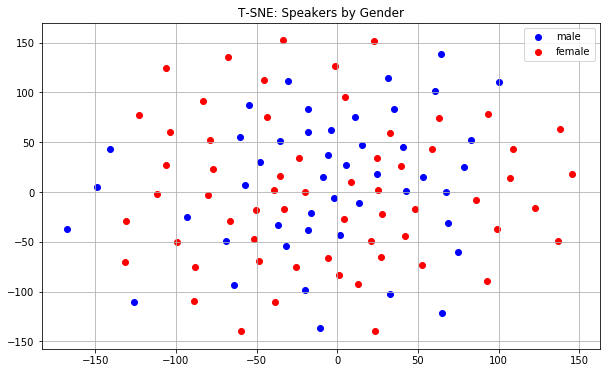

In [18]:
plt.figure(figsize=(10,6))
m_plot = plt.scatter(tsne_fit[idx_m, 0], tsne_fit[idx_m, 1], c='b', label='male')
f_plot = plt.scatter(tsne_fit[idx_f, 0], tsne_fit[idx_f, 1], c='r', label='female')
leg = plt.legend(handles=[m_plot, f_plot])
plt.grid(True)
plt.title('T-SNE: Speakers by Gender')
plt.show()

In [19]:
checkpoint_file = '/home/ubuntu/msc-project-fader-networks/checkpoints/discriminator_test/minmodel.pth'

In [39]:
# generate the sample
spkr_id = 0
#text = 'The threats would be a major escalation of the dispute and sparked further falls on stock markets.'
text = 'China responded by accusing the US of blackmail'
text = 'How trying to stay cool could make the world even hotter'
#text = 'he picked his tooth up off the floor'
npz='p311_111.npz'
text = ''
loop_dict = nu.generate_sample_with_loop(spkr_id=spkr_id, 
                                      npz=npz, 
                                      text=text, 
                                      checkpoint=checkpoint_file, 
                                      output_dir ='./',
                                      npz_path = '/home/ubuntu/loop/data/vctk-16khz-cmu-no-boundaries-all/numpy_features')

./
p311_111_0
/home/ubuntu/loop/data/vctk-16khz-cmu-no-boundaries-all/norm_info/norm.dat


CalledProcessError: Command 'echo 1 1 1.4 1.4 1.4 1.4 1.4 1.4 1.4 1.4 1.4 1.4 1.4 1.4 1.4 1.4 1.4 1.4 1.4 1.4 1.4 1.4 1.4 1.4 1.4 1.4 1.4 1.4 1.4 1.4 1.4 1.4 1.4 1.4 1.4 1.4 1.4 1.4 1.4 1.4 1.4 1.4 1.4 1.4 1.4 1.4 1.4 1.4 1.4 1.4 1.4 1.4 1.4 1.4 1.4 1.4 1.4 1.4 1.4 1.4  | /tools/SPTK-3.9/x2x +af > /home/ubuntu/msc-project-fader-networks/weight' returned non-zero exit status 127

In [608]:
# listen to the original (if based on a known sample)
if npz:
    IPython.display.display(Audio(loop_dict['output_orig_fname'] + '.wav', autoplay=True))

In [30]:
# listen to sample synthesized from VoiceLoop features
Audio(loop_dict['output_file'] + '.wav', autoplay=True)

In [31]:
loop_dict['output_file'] 

'How_trying_to_stay_cool_could_make_the_world_even_hotter'